In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### Nodes & Edges

In [2]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph


def add_one(input: list[HumanMessage]):
    input[0].content = input[0].content + "a"
    return input

graph = MessageGraph()

graph.add_node("branch_a", add_one)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_a", "branch_c")

graph.add_node("branch_b", add_one)
graph.add_node("branch_c", add_one)

graph.add_edge("branch_b", "final_node")
graph.add_edge("branch_c", "final_node")

graph.add_node("final_node", add_one)
graph.add_edge("final_node", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()


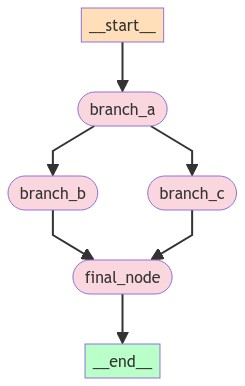

In [3]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [4]:
runnable.invoke("a")

[HumanMessage(content='aaaaa', id='199bca4d-7ac9-43bc-8476-3862f1bf94e4')]

### Conditional Edges

In [5]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph


def entry(input: list[HumanMessage]):
    return input

def work_with_b(input: list[HumanMessage]):
    print("Using branch B")
    return input

def work_with_c(input: list[HumanMessage]):
    print("Using branch C")
    return input

def router(input: list[HumanMessage]):
    if "use_b" in input[0].content:
        return "branch_b"
    else:
        return "branch_c"

graph = MessageGraph()

graph.add_node("branch_a", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)

graph.add_conditional_edges(
    "branch_a",
    router,
    {"branch_b": "branch_b", "branch_c": "branch_c"}
)
graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

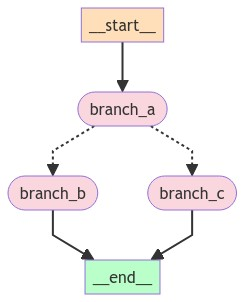

In [6]:
display(Image(runnable.get_graph().draw_mermaid_png()))

In [7]:
runnable.invoke("hello")

Using branch C


[HumanMessage(content='hello', id='f9406ddd-cce9-4032-8844-c41f7a1815c2')]

In [8]:
runnable.invoke("I want to use_b")

Using branch B


[HumanMessage(content='I want to use_b', id='a4d96568-19e7-4606-a70d-b97eef530a37')]

### Cycles

In [9]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

model = ChatOpenAI(temperature=0)

def entry(input: list[HumanMessage]):
    return input

def action(input: list[HumanMessage]):
    print("Action taken:", [msg.content for msg in input])
    if len(input) > 5:
        input.append(HumanMessage(content="end"))
    else:
        input.append(HumanMessage(content="continue"))
    return input

def should_continue(input: list):
    last_message = input[-1]
    if "end" in last_message.content:
        return "__end__"
    return "action"


graph = MessageGraph()

graph.add_node("agent", entry)
graph.add_node("action", action)

graph.add_conditional_edges(
    "agent",
    should_continue,
    {"action": "action", "__end__": END}
)
graph.add_edge("action", "agent")

graph.set_entry_point("agent")

runnable = graph.compile()


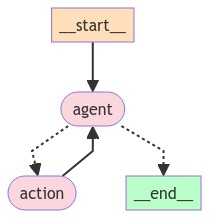

In [10]:
display(Image(runnable.get_graph().draw_mermaid_png()))

In [11]:
runnable.invoke("Hello")

Action taken: ['Hello']
Action taken: ['Hello', 'continue']
Action taken: ['Hello', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue', 'continue']


[HumanMessage(content='Hello', id='c87823b2-1a4d-40d1-8489-33b9cafe36b2'),
 HumanMessage(content='continue', id='df77a69f-9736-4ede-b43e-4bc936cb1762'),
 HumanMessage(content='continue', id='cd389c44-e857-4f0a-9baf-8f26fbe5f1be'),
 HumanMessage(content='continue', id='a0741a27-cade-44aa-abb9-e04ba863d62b'),
 HumanMessage(content='continue', id='a983b8fc-479a-4696-97a7-92f48296080d'),
 HumanMessage(content='continue', id='9316f244-791b-4488-b075-733440527c29'),
 HumanMessage(content='end', id='fd45df26-660a-4a99-89ec-9def4838a428')]

### Real Agent - now lets create an Agent that actually does something

In [12]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)


In [13]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    api_call_count: int = 0

In [14]:
from langchain_core.tools import tool
import random

@tool
def fake_weather_api(city: str) -> str:
    """Check the weather in a specified city. The API is available randomly, approximately every third call."""

    if random.randint(1, 3) == 1:  # Approximately one-third chance
        return "Sunny, 22°C"
    else:
        return "Service temporarily unavailable"

In [15]:
print(fake_weather_api("New York"))
print(fake_weather_api("London"))
print(fake_weather_api("Berlin"))

Service temporarily unavailable
Service temporarily unavailable
Sunny, 22°C


c:\Users\User\Desktop\langgraph\app\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [16]:
llm_with_tools = model.bind_tools([fake_weather_api])

In [17]:
from langchain_core.messages import HumanMessage, ToolMessage

tool_mapping = {"fake_weather_api": fake_weather_api}

messages = [HumanMessage("How will the weather be in munich today? I would like to eat outside if possible")]
llm_output = llm_with_tools.invoke(messages)
messages.append(llm_output)
print(messages)

[HumanMessage(content='How will the weather be in munich today? I would like to eat outside if possible'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ivnyhRcPyvqWRerdQ0lLKX3G', 'function': {'arguments': '{"city":"Munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 86, 'total_tokens': 103}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-82ca7f6c-ee6d-427e-9f3a-f3bfe7ee5fc2-0', tool_calls=[{'name': 'fake_weather_api', 'args': {'city': 'Munich'}, 'id': 'call_ivnyhRcPyvqWRerdQ0lLKX3G'}])]


In [18]:
for tool_call in llm_output.tool_calls:
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

llm_with_tools.invoke(messages)

AIMessage(content="I'm sorry, but it seems that the weather service is temporarily unavailable. Would you like me to try again or provide information for a different city?", response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 115, 'total_tokens': 146}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-c3256bb0-5b7d-43b1-8a38-73f0e3c50416-0')

In [19]:
def should_continue(state: AgentState):
    print("STATE:", state)
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

def call_model(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response], "api_call_count": state["api_call_count"]}

def call_tool(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    state['api_call_count'] += 1
    print("Tool output:", tool_output)
    print("API call count after this tool call:", state['api_call_count'])
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages": [tool_message], "api_call_count": state["api_call_count"]}


In [20]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)
workflow.add_edge("action", "agent")
workflow.set_entry_point("agent")

app = workflow.compile()

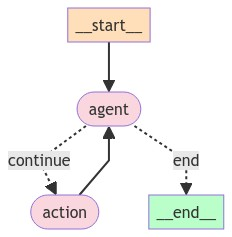

In [21]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [22]:
from langchain_core.messages import SystemMessage

system_message =  SystemMessage(content="You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again")
human_message = HumanMessage(content="How is the weather in munich today?")
messages = [system_message, human_message]

result = app.invoke({"messages": messages, "api_call_count": 0})

STATE: {'messages': [SystemMessage(content='You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again'), HumanMessage(content='How is the weather in munich today?'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_iovcj3H7kH3WjEoYb13KHRxj', 'function': {'arguments': '{"city":"munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 105, 'total_tokens': 121}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6af12865-765f-4537-b1b7-61674c1680c0-0', tool_calls=[{'name': 'fake_weather_api', 'args': {'city': 'munich'}, 'id': 'call_iovcj3H7kH3WjEoYb13KHRxj'}])], 'api_call_count': 0}
Tool output: Service temporarily unavailable
API call count after this tool call: 1
STATE: {'messages': [SystemMessage(content='You are responsible for 

In [23]:
print(result["messages"][-1].content)
print(result["api_call_count"])

The weather in Munich today is sunny with a temperature of 22°C.
2
